In [ ]:
# Intallation packages before use Jupyter

# !pip install pandas
# !pip install -U scikit-learn
# !pip install keras
# !pip install matplotlib
# !pip install kaleido
# !pip install plotly

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
# from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from math import sqrt
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# be able to save images on server
matplotlib.use('Agg')

# Not show warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# !pip install -U kaleido # w Google Colab wymagany Runtime restart po instalacji (Runtime -> Restart Runtime)
import kaleido #required
# kaleido.__version__ #0.2.1

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2024-06-18 11:47:27.201857: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.16.1
Num GPUs Available:  1


In [ ]:
# Zip
# importing the "tarfile" module
import tarfile # type: ignore

# open file
file = tarfile.open('1_150x9.tar.gz')

# extracting a specific file
file.extractall(path='./1_150x9/')

file.close()

In [2]:
# Data generator
def data(time):
    # Timestep 
    # timestepsPerSample = 20
    timestepsPerSample = time

    # Timesteps in input data
    timestepsPerSampleWholeData = 150

    # Replace 'your_file.csv' with the actual file path
    file_features = './1_150x9/1_150x9f.csv'
    file_labels = './1_150x9/1_150x9l.csv'

    # Read the .csv file and create an array
    data_strings = np.genfromtxt(file_features, delimiter=';')
    labels_strings = np.genfromtxt(file_labels,delimiter=';')

    # Wycinanie wybranych kolumn
    #  0    1         2             3        4       5        6    7        8
    # RSI, VWAP, HeikenResult, closeHeiken, CMF, Stochastic, OBV, QQE, TrendFilter
    # data_s = data_strings[:,[0,2,3,4,5,6,7,8]]
    data_s = data_strings[:,[0,4,5,8]]
    num_features = data_s.shape[1]
    # print(data_strings[:3])
    # print(data_s[:3])
    
    # Convert from strings to float and int
    X = data_s.astype(float).reshape((-1,timestepsPerSampleWholeData,num_features))
    Y = labels_strings.astype(float).reshape((-1,3))
    # print(X.shape)
    # print(Y.shape)

    # Modification from imported to new size X[samples,timesteps]
    X_mod = X[1000:11000,timestepsPerSampleWholeData - timestepsPerSample:]
    Y_mod = Y[1000:11000]
    timestepsPerSampleWholeData = X_mod.shape[1]
    # print(X_mod.shape)
    # print(Y_mod.shape)
    # print(X_mod[:1])

    # Splitting
    x_train, x_test, Y_train, Y_test = train_test_split(X_mod,Y_mod, test_size=0.15, shuffle=False)
    y_train = Y_train[:, 0:2]
    y_test = Y_test[:, 0:2]
    # print(y_train[:2])
    # print(y_test[:2])

    # Summarize
    num_samples = x_train.shape[0]
    test_samples = x_test.shape[0]
    print(f"Train shape: {x_train.shape}")
    print(f"Timesteps: {timestepsPerSampleWholeData}")
    print(f"Num Samples: {num_samples}")
    print(f"Test Samples: {test_samples}")
    print(f"Num features: {num_features}")
    return x_train, x_test, y_train, y_test, Y_test

In [7]:
# fit lstm model
from tabnanny import verbose


def fit_lstmModel(x_train, y_train, x_test, y_test, batch_size, nb_epoch, neurons, denseType, dropout, model):
    if model == 0:
        model = Sequential()

        # Assuming `data` is your input matrix with shape (samples, time_steps, features)
        model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
        model.add(Dropout(0.2))

        model.add(LSTM(units=50, return_sequences=False))
        model.add(Dropout(0.2))

        model.add(Dense(units=25))
        model.add(Dropout(0.2))

        # Output layer for price prediction
        model.add(Dense(y_train.shape[1], activation='sigmoid'))

    elif model == 1:
        model = Sequential()

        # Assuming `data` is your input matrix with shape (samples, time_steps, features)
        model.add(LSTM(units=150, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
        model.add(Dropout(0.2))

        model.add(LSTM(units=150, return_sequences=False))
        model.add(Dropout(0.2))

        model.add(Dense(units=75))
        model.add(Dropout(0.2))

        # Output layer for price prediction
        model.add(Dense(y_train.shape[1], activation='sigmoid'))

    elif model == 2:
        model = Sequential()

        # Assuming `data` is your input matrix with shape (samples, time_steps, features)
        model.add(LSTM(units=300, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
        model.add(Dropout(0.2))

        model.add(LSTM(units=300, return_sequences=False))
        model.add(Dropout(0.2))

        model.add(Dense(units=150))
        model.add(Dropout(0.2))

        # Output layer for price prediction
        model.add(Dense(y_train.shape[1], activation='sigmoid'))

    
    num_samples = x_train.shape[0]
    STEPS_PER_EPOCH = num_samples/batch_size

    # lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*100,
    decay_rate=0.9,
    staircase=False)

    # Callback EarlyStopping
    callback = EarlyStopping(monitor='val_loss',
                                             start_from_epoch=10,
                                             restore_best_weights=True,
                                             verbose=0,
                                             patience=5)

    def get_optimizer():
         # return tf.keras.optimizers.Adam(learning_rate=0.001)
        return tf.keras.optimizers.Adam(learning_rate= lr_schedule) # type: ignore

    optimizer = get_optimizer()

    # defining loss function, optimizer, metrics and then compiling model
    model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    model.summary()

    # fit model
    history = model.fit(x_train, y_train, epochs=nb_epoch, batch_size=batch_size, 
                        shuffle=False, validation_data=(x_test, y_test), callbacks=callback, verbose=2) # type: ignore
    return model, history

In [3]:
# Profit
def funcProfit(predict, Y_test):
    predict_classes = np.where(predict > 0.5, 1,0)
    concat = np.hstack((predict_classes, Y_test[:,2:]))
    df = pd.DataFrame(concat, columns=['Sell', 'Buy', 'Price'])

    # Absolute difference prices
    sum = 0
    for i in range(0, len(df)):
        if (i-1) > 0:
            diff = abs((df.at[i,'Price'] - df.at[i-1,'Price']))
            if diff < 0.5:
                if df.at[i,'Sell'] == 1:
                    sum += (df.at[i,'Price'] - df.at[i-1,'Price'])*(-1)
                elif df.at[i,'Buy'] == 1:
                    sum += (df.at[i,'Price'] - df.at[i-1,'Price'])
                if df.at[i,'Sell'] != df.at[i-1,'Sell']:
                    sum -= 0.03
    return sum

In [4]:
# Experiment
def experiment(repeats, epochs, neurons, time, denseType, dropout, model):
    # Data gen
    x_train, x_test, y_train, y_test, Y_test = data(time)

    # Evaluate declaration
    accuracy = list()
    profit = list()
    metrics = list()

    # Repeats
    for r in range(repeats):
        print(f"Repeat {r} running...")
        # Batch size
        batch_size = 64
        # model
        model, history = fit_lstmModel(x_train, y_train, x_test, y_test, batch_size, epochs, neurons, denseType, dropout, model)

        # forecast the entire training dataset to build up state for forecasting
        predict = model.predict(x_test, batch_size=batch_size)
        test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0) # type: ignore

        metric = pd.DataFrame(history.history)
        metric['epoch'] = history.epoch

        metrics.append(metric)
        accuracy.append(test_acc*100)
        profit.append(funcProfit(predict, Y_test))
    
    return accuracy, profit, metrics

In [5]:
# Output
def plotsOut(d, metrics):
    fig = make_subplots(rows=1, cols=2, subplot_titles=('Accuracy', 'Loss'))

    # Layout - set size
    fig.update_layout(
        autosize=True,
        width=1000
    )

    for idx, m in enumerate(metrics):
        fig.add_trace(go.Scatter(x=m['epoch'], y=m['accuracy'], name=f'accuracy{str(idx)}', line_color='#0000ff', showlegend=False), row=1, col=1)
        fig.add_trace(go.Scatter(x=m['epoch'], y=m['loss'], name=f'loss{str(idx)}', line_color='#0000ff', showlegend=False), row=1, col=2)
        fig.add_trace(go.Scatter(x=m['epoch'], y=m['val_accuracy'], name=f'val_accuracy{str(idx)}', line_color='#EF8260', showlegend=False), row=1, col=1)
        fig.add_trace(go.Scatter(x=m['epoch'], y=m['val_loss'], name=f'val_loss{str(idx)}', line_color='#EF8260', showlegend=False), row=1, col=2)

    fig.update_xaxes(title_text='epochs')
    fig.update_yaxes(title_text='')
    # fig.update_layout(width=1000, title='Accuracy and Loss')
    fig.write_image(file=f"compare_models_{str(d)}.jpg", engine="kaleido")

In [8]:
# Run
from numpy import dtype

repeats = 4
results_acc = DataFrame(dtype='float')
results_profit = DataFrame(dtype='float')
metrics = list()

# vary training epochs
model = [0, 1, 2]
dropout = 0.2
denseType = 0
neuronsLstm = 150
timeStep = 150
epochs = 100
for mod in model:
 print(f"{mod} Model test start...")
 results_acc[str(mod)], results_profit[str(mod)], metrics = experiment(repeats, epochs, neuronsLstm, timeStep, denseType, dropout, mod)
 plotsOut(mod, metrics)

# summarize results
print(results_acc.describe())
print(results_profit.describe())

0 Model test start...
Train shape: (8500, 150, 4)
Timesteps: 150
Num Samples: 8500
Test Samples: 1500
Num features: 4
Repeat 0 running...


2024-06-18 11:48:48.289617: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6264 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:09:00.0, compute capability: 8.6
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 150, 50)        │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 150, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,527 (127.06 KB)

 Trainable params: 32,527 (127.06 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


2024-06-18 11:48:51.629209: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


133/133 - 8s - 60ms/step - accuracy: 0.6066 - loss: 0.6645 - val_accuracy: 0.6527 - val_loss: 0.6390
Epoch 2/100
133/133 - 4s - 27ms/step - accuracy: 0.6353 - loss: 0.6435 - val_accuracy: 0.6753 - val_loss: 0.6132
Epoch 3/100
133/133 - 4s - 28ms/step - accuracy: 0.6487 - loss: 0.6347 - val_accuracy: 0.6827 - val_loss: 0.6044
Epoch 4/100
133/133 - 4s - 27ms/step - accuracy: 0.6586 - loss: 0.6284 - val_accuracy: 0.6867 - val_loss: 0.5971
Epoch 5/100
133/133 - 4s - 27ms/step - accuracy: 0.6608 - loss: 0.6207 - val_accuracy: 0.6933 - val_loss: 0.5895
Epoch 6/100
133/133 - 4s - 27ms/step - accuracy: 0.6674 - loss: 0.6150 - val_accuracy: 0.6980 - val_loss: 0.5808
Epoch 7/100
133/133 - 4s - 27ms/step - accuracy: 0.6786 - loss: 0.6068 - val_accuracy: 0.7067 - val_loss: 0.5708
Epoch 8/100
133/133 - 4s - 27ms/step - accuracy: 0.6855 - loss: 0.6015 - val_accuracy: 0.7147 - val_loss: 0.5614
Epoch 9/100
133/133 - 4s - 27ms/step - accuracy: 0.6882 - loss: 0.5937 - val_accuracy: 0.7267 - val_loss: 0.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 150, 50)        │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 150, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,527 (127.06 KB)

 Trainable params: 32,527 (127.06 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
133/133 - 6s - 48ms/step - accuracy: 0.7035 - loss: 0.5784 - val_accuracy: 0.7280 - val_loss: 0.5518
Epoch 2/100
133/133 - 4s - 27ms/step - accuracy: 0.6999 - loss: 0.5816 - val_accuracy: 0.7293 - val_loss: 0.5450
Epoch 3/100
133/133 - 4s - 27ms/step - accuracy: 0.7068 - loss: 0.5771 - val_accuracy: 0.7313 - val_loss: 0.5534
Epoch 4/100
133/133 - 4s - 27ms/step - accuracy: 0.7021 - loss: 0.5775 - val_accuracy: 0.7273 - val_loss: 0.5438
Epoch 5/100
133/133 - 4s - 27ms/step - accuracy: 0.7052 - loss: 0.5775 - val_accuracy: 0.7287 - val_loss: 0.5557
Epoch 6/100
133/133 - 4s - 27ms/step - accuracy: 0.7066 - loss: 0.5756 - val_accuracy: 0.7280 - val_loss: 0.5544
Epoch 7/100
133/133 - 4s - 27ms/step - accuracy: 0.7087 - loss: 0.5725 - val_accuracy: 0.7280 - val_loss: 0.5531
Epoch 8/100
133/133 - 4s - 26ms/step - accuracy: 0.7091 - loss: 0.5713 - val_accuracy: 0.7220 - val_loss: 0.5525
Epoch 9/100
133/133 - 4s - 27ms/step - accuracy: 0.7004 - loss: 0.5895 - val_accuracy: 0.7240 - 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 150, 50)        │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 150, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,527 (127.06 KB)

 Trainable params: 32,527 (127.06 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
133/133 - 6s - 46ms/step - accuracy: 0.7068 - loss: 0.5713 - val_accuracy: 0.7287 - val_loss: 0.5455
Epoch 2/100
133/133 - 4s - 27ms/step - accuracy: 0.7006 - loss: 0.5830 - val_accuracy: 0.7273 - val_loss: 0.5440
Epoch 3/100
133/133 - 4s - 27ms/step - accuracy: 0.7025 - loss: 0.5793 - val_accuracy: 0.7153 - val_loss: 0.5419
Epoch 4/100
133/133 - 4s - 27ms/step - accuracy: 0.7158 - loss: 0.5635 - val_accuracy: 0.7293 - val_loss: 0.5422
Epoch 5/100
133/133 - 4s - 27ms/step - accuracy: 0.7132 - loss: 0.5727 - val_accuracy: 0.7227 - val_loss: 0.5457
Epoch 6/100
133/133 - 4s - 27ms/step - accuracy: 0.7144 - loss: 0.5677 - val_accuracy: 0.7307 - val_loss: 0.5517
Epoch 7/100
133/133 - 4s - 27ms/step - accuracy: 0.6706 - loss: 0.6081 - val_accuracy: 0.6880 - val_loss: 0.5996
Epoch 8/100
133/133 - 4s - 27ms/step - accuracy: 0.6524 - loss: 0.6335 - val_accuracy: 0.7013 - val_loss: 0.5793
Epoch 9/100
133/133 - 4s - 27ms/step - accuracy: 0.6702 - loss: 0.6150 - val_accuracy: 0.7080 - 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 150, 50)        │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 150, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,527 (127.06 KB)

 Trainable params: 32,527 (127.06 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
133/133 - 7s - 50ms/step - accuracy: 0.7014 - loss: 0.5816 - val_accuracy: 0.7320 - val_loss: 0.5483
Epoch 2/100
133/133 - 4s - 28ms/step - accuracy: 0.7021 - loss: 0.5802 - val_accuracy: 0.7300 - val_loss: 0.5449
Epoch 3/100
133/133 - 4s - 27ms/step - accuracy: 0.7028 - loss: 0.5766 - val_accuracy: 0.7320 - val_loss: 0.5457
Epoch 4/100
133/133 - 4s - 27ms/step - accuracy: 0.6986 - loss: 0.5804 - val_accuracy: 0.7327 - val_loss: 0.5454
Epoch 5/100
133/133 - 4s - 27ms/step - accuracy: 0.7028 - loss: 0.5761 - val_accuracy: 0.7260 - val_loss: 0.5446
Epoch 6/100
133/133 - 4s - 27ms/step - accuracy: 0.7045 - loss: 0.5748 - val_accuracy: 0.7280 - val_loss: 0.5459
Epoch 7/100
133/133 - 4s - 27ms/step - accuracy: 0.7040 - loss: 0.5767 - val_accuracy: 0.7273 - val_loss: 0.5452
Epoch 8/100
133/133 - 4s - 27ms/step - accuracy: 0.7062 - loss: 0.5737 - val_accuracy: 0.7327 - val_loss: 0.5423
Epoch 9/100
133/133 - 4s - 27ms/step - accuracy: 0.7035 - loss: 0.5766 - val_accuracy: 0.7293 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 150, 150)       │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 150, 150)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,077 (1.09 MB)

 Trainable params: 285,077 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
133/133 - 7s - 51ms/step - accuracy: 0.6139 - loss: 0.6618 - val_accuracy: 0.6747 - val_loss: 0.6275
Epoch 2/100
133/133 - 4s - 32ms/step - accuracy: 0.6522 - loss: 0.6302 - val_accuracy: 0.6880 - val_loss: 0.6001
Epoch 3/100
133/133 - 4s - 32ms/step - accuracy: 0.6632 - loss: 0.6189 - val_accuracy: 0.6920 - val_loss: 0.5861
Epoch 4/100
133/133 - 4s - 32ms/step - accuracy: 0.6778 - loss: 0.6076 - val_accuracy: 0.7120 - val_loss: 0.5688
Epoch 5/100
133/133 - 4s - 33ms/step - accuracy: 0.6905 - loss: 0.5984 - val_accuracy: 0.7240 - val_loss: 0.5585
Epoch 6/100
133/133 - 4s - 33ms/step - accuracy: 0.6951 - loss: 0.5924 - val_accuracy: 0.7240 - val_loss: 0.5523
Epoch 7/100
133/133 - 4s - 33ms/step - accuracy: 0.6955 - loss: 0.5892 - val_accuracy: 0.7253 - val_loss: 0.5514
Epoch 8/100
133/133 - 4s - 33ms/step - accuracy: 0.6959 - loss: 0.5868 - val_accuracy: 0.7227 - val_loss: 0.5488
Epoch 9/100
133/133 - 4s - 33ms/step - accuracy: 0.6979 - loss: 0.5861 - val_accuracy: 0.7267 - 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 150, 150)       │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 150, 150)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,077 (1.09 MB)

 Trainable params: 285,077 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
133/133 - 7s - 51ms/step - accuracy: 0.7016 - loss: 0.5787 - val_accuracy: 0.7233 - val_loss: 0.5511
Epoch 2/100
133/133 - 4s - 32ms/step - accuracy: 0.6993 - loss: 0.5808 - val_accuracy: 0.7247 - val_loss: 0.5479
Epoch 3/100
133/133 - 4s - 33ms/step - accuracy: 0.7016 - loss: 0.5760 - val_accuracy: 0.7260 - val_loss: 0.5448
Epoch 4/100
133/133 - 4s - 33ms/step - accuracy: 0.7012 - loss: 0.5749 - val_accuracy: 0.7220 - val_loss: 0.5486
Epoch 5/100
133/133 - 4s - 32ms/step - accuracy: 0.7062 - loss: 0.5755 - val_accuracy: 0.7187 - val_loss: 0.5510
Epoch 6/100
133/133 - 4s - 33ms/step - accuracy: 0.7021 - loss: 0.5789 - val_accuracy: 0.7193 - val_loss: 0.5524
Epoch 7/100
133/133 - 4s - 33ms/step - accuracy: 0.7024 - loss: 0.5766 - val_accuracy: 0.7200 - val_loss: 0.5462
Epoch 8/100
133/133 - 4s - 32ms/step - accuracy: 0.7053 - loss: 0.5755 - val_accuracy: 0.7213 - val_loss: 0.5461
Epoch 9/100
133/133 - 4s - 33ms/step - accuracy: 0.7067 - loss: 0.5734 - val_accuracy: 0.7227 - 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 150, 150)       │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 150, 150)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,077 (1.09 MB)

 Trainable params: 285,077 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
133/133 - 7s - 52ms/step - accuracy: 0.7159 - loss: 0.5599 - val_accuracy: 0.7213 - val_loss: 0.5548
Epoch 2/100
133/133 - 4s - 32ms/step - accuracy: 0.7134 - loss: 0.5600 - val_accuracy: 0.7160 - val_loss: 0.5599
Epoch 3/100
133/133 - 4s - 33ms/step - accuracy: 0.7184 - loss: 0.5563 - val_accuracy: 0.7187 - val_loss: 0.5521
Epoch 4/100
133/133 - 4s - 32ms/step - accuracy: 0.7181 - loss: 0.5582 - val_accuracy: 0.7200 - val_loss: 0.5522
Epoch 5/100
133/133 - 4s - 33ms/step - accuracy: 0.7152 - loss: 0.5614 - val_accuracy: 0.7300 - val_loss: 0.5470
Epoch 6/100
133/133 - 4s - 33ms/step - accuracy: 0.7175 - loss: 0.5573 - val_accuracy: 0.7240 - val_loss: 0.5489
Epoch 7/100
133/133 - 4s - 32ms/step - accuracy: 0.7209 - loss: 0.5515 - val_accuracy: 0.7200 - val_loss: 0.5493
Epoch 8/100
133/133 - 4s - 33ms/step - accuracy: 0.7226 - loss: 0.5502 - val_accuracy: 0.7180 - val_loss: 0.5538
Epoch 9/100
133/133 - 4s - 33ms/step - accuracy: 0.7238 - loss: 0.5492 - val_accuracy: 0.7213 - 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 150, 150)       │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 150, 150)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,077 (1.09 MB)

 Trainable params: 285,077 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
133/133 - 8s - 56ms/step - accuracy: 0.7291 - loss: 0.5533 - val_accuracy: 0.7040 - val_loss: 0.5559
Epoch 2/100
133/133 - 4s - 32ms/step - accuracy: 0.7344 - loss: 0.5372 - val_accuracy: 0.7000 - val_loss: 0.5604
Epoch 3/100
133/133 - 4s - 32ms/step - accuracy: 0.7251 - loss: 0.5405 - val_accuracy: 0.7007 - val_loss: 0.5622
Epoch 4/100
133/133 - 4s - 32ms/step - accuracy: 0.7351 - loss: 0.5296 - val_accuracy: 0.6913 - val_loss: 0.5848
Epoch 5/100
133/133 - 4s - 32ms/step - accuracy: 0.7348 - loss: 0.5320 - val_accuracy: 0.6933 - val_loss: 0.5599
Epoch 6/100
133/133 - 4s - 32ms/step - accuracy: 0.7404 - loss: 0.5216 - val_accuracy: 0.6720 - val_loss: 0.6181
Epoch 7/100
133/133 - 4s - 33ms/step - accuracy: 0.7342 - loss: 0.5360 - val_accuracy: 0.6493 - val_loss: 0.6139
Epoch 8/100
133/133 - 4s - 32ms/step - accuracy: 0.6945 - loss: 0.5806 - val_accuracy: 0.6973 - val_loss: 0.5690
Epoch 9/100
133/133 - 4s - 33ms/step - accuracy: 0.7116 - loss: 0.5650 - val_accuracy: 0.6273 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 150, 300)       │       366,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 150, 300)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 300)            │       721,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 150)            │        45,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           302 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,132,652 (4.32 MB)

 Trainable params: 1,132,652 (4.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
133/133 - 7s - 55ms/step - accuracy: 0.6018 - loss: 0.6668 - val_accuracy: 0.6727 - val_loss: 0.6275
Epoch 2/100
133/133 - 4s - 33ms/step - accuracy: 0.6552 - loss: 0.6293 - val_accuracy: 0.6887 - val_loss: 0.5959
Epoch 3/100
133/133 - 4s - 32ms/step - accuracy: 0.6726 - loss: 0.6123 - val_accuracy: 0.6993 - val_loss: 0.5747
Epoch 4/100
133/133 - 4s - 33ms/step - accuracy: 0.6844 - loss: 0.5996 - val_accuracy: 0.7200 - val_loss: 0.5652
Epoch 5/100
133/133 - 4s - 33ms/step - accuracy: 0.6828 - loss: 0.6187 - val_accuracy: 0.7233 - val_loss: 0.5609
Epoch 6/100
133/133 - 4s - 33ms/step - accuracy: 0.6907 - loss: 0.5925 - val_accuracy: 0.7253 - val_loss: 0.5554
Epoch 7/100
133/133 - 4s - 34ms/step - accuracy: 0.6936 - loss: 0.5889 - val_accuracy: 0.7247 - val_loss: 0.5519
Epoch 8/100
133/133 - 4s - 33ms/step - accuracy: 0.6914 - loss: 0.5891 - val_accuracy: 0.7260 - val_loss: 0.5503
Epoch 9/100
133/133 - 4s - 33ms/step - accuracy: 0.6961 - loss: 0.5890 - val_accuracy: 0.7280 - 

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 150, 300)       │       366,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 150, 300)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 300)            │       721,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 150)            │        45,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           302 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,132,652 (4.32 MB)

 Trainable params: 1,132,652 (4.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
133/133 - 7s - 54ms/step - accuracy: 0.6952 - loss: 0.5839 - val_accuracy: 0.7260 - val_loss: 0.5487
Epoch 2/100
133/133 - 4s - 33ms/step - accuracy: 0.6985 - loss: 0.5836 - val_accuracy: 0.7220 - val_loss: 0.5475
Epoch 3/100
133/133 - 4s - 32ms/step - accuracy: 0.6989 - loss: 0.5833 - val_accuracy: 0.7220 - val_loss: 0.5461
Epoch 4/100
133/133 - 4s - 32ms/step - accuracy: 0.7024 - loss: 0.5825 - val_accuracy: 0.7200 - val_loss: 0.5484
Epoch 5/100
133/133 - 4s - 33ms/step - accuracy: 0.7011 - loss: 0.5820 - val_accuracy: 0.7253 - val_loss: 0.5502
Epoch 6/100
133/133 - 4s - 33ms/step - accuracy: 0.6981 - loss: 0.5817 - val_accuracy: 0.7233 - val_loss: 0.5527
Epoch 7/100
133/133 - 4s - 32ms/step - accuracy: 0.6995 - loss: 0.5783 - val_accuracy: 0.7207 - val_loss: 0.5508
Epoch 8/100
133/133 - 4s - 33ms/step - accuracy: 0.7000 - loss: 0.5785 - val_accuracy: 0.7227 - val_loss: 0.5549
Epoch 9/100
133/133 - 4s - 33ms/step - accuracy: 0.7052 - loss: 0.5783 - val_accuracy: 0.7233 - 

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 150, 300)       │       366,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 150, 300)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 300)            │       721,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 150)            │        45,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           302 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,132,652 (4.32 MB)

 Trainable params: 1,132,652 (4.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
133/133 - 7s - 53ms/step - accuracy: 0.7085 - loss: 0.5712 - val_accuracy: 0.7240 - val_loss: 0.5381
Epoch 2/100
133/133 - 4s - 33ms/step - accuracy: 0.7119 - loss: 0.5640 - val_accuracy: 0.7220 - val_loss: 0.5406
Epoch 3/100
133/133 - 4s - 33ms/step - accuracy: 0.7152 - loss: 0.5625 - val_accuracy: 0.7113 - val_loss: 0.5604
Epoch 4/100
133/133 - 4s - 34ms/step - accuracy: 0.7124 - loss: 0.5646 - val_accuracy: 0.7260 - val_loss: 0.5406
Epoch 5/100
133/133 - 4s - 33ms/step - accuracy: 0.7099 - loss: 0.5673 - val_accuracy: 0.7220 - val_loss: 0.5396
Epoch 6/100
133/133 - 4s - 34ms/step - accuracy: 0.7188 - loss: 0.5588 - val_accuracy: 0.7080 - val_loss: 0.5631
Epoch 7/100
133/133 - 4s - 34ms/step - accuracy: 0.7152 - loss: 0.5581 - val_accuracy: 0.7140 - val_loss: 0.5556
Epoch 8/100
133/133 - 4s - 33ms/step - accuracy: 0.7179 - loss: 0.5568 - val_accuracy: 0.7173 - val_loss: 0.5558
Epoch 9/100
133/133 - 4s - 33ms/step - accuracy: 0.7169 - loss: 0.5565 - val_accuracy: 0.7213 - 

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 150, 300)       │       366,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 150, 300)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 300)            │       721,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 150)            │        45,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           302 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,132,652 (4.32 MB)

 Trainable params: 1,132,652 (4.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
133/133 - 7s - 56ms/step - accuracy: 0.7214 - loss: 0.5465 - val_accuracy: 0.7107 - val_loss: 0.5609
Epoch 2/100
133/133 - 4s - 33ms/step - accuracy: 0.7260 - loss: 0.5479 - val_accuracy: 0.7113 - val_loss: 0.5451
Epoch 3/100
133/133 - 4s - 33ms/step - accuracy: 0.7316 - loss: 0.5349 - val_accuracy: 0.6940 - val_loss: 0.5736
Epoch 4/100
133/133 - 4s - 33ms/step - accuracy: 0.7267 - loss: 0.5402 - val_accuracy: 0.6953 - val_loss: 0.5723
Epoch 5/100
133/133 - 4s - 33ms/step - accuracy: 0.7285 - loss: 0.5469 - val_accuracy: 0.7127 - val_loss: 0.5450
Epoch 6/100
133/133 - 4s - 33ms/step - accuracy: 0.7344 - loss: 0.5385 - val_accuracy: 0.7047 - val_loss: 0.5627
Epoch 7/100
133/133 - 4s - 33ms/step - accuracy: 0.7339 - loss: 0.5371 - val_accuracy: 0.7147 - val_loss: 0.5820
Epoch 8/100
133/133 - 4s - 33ms/step - accuracy: 0.7498 - loss: 0.5271 - val_accuracy: 0.7067 - val_loss: 0.5934
Epoch 9/100
133/133 - 4s - 33ms/step - accuracy: 0.7358 - loss: 0.5362 - val_accuracy: 0.7193 - 

In [9]:
# summarize results
print(results_acc.describe())
print(results_profit.describe())

               0          1          2
count   4.000000   4.000000   4.000000
mean   72.749999  71.766666  72.166666
std     0.382488   1.225047   0.363116
min    72.399998  70.666665  71.733332
25%    72.449999  70.766667  71.983331
50%    72.700000  71.633333  72.166666
75%    73.000000  72.633332  72.350001
max    73.199999  73.133332  72.600001
              0        1         2
count  4.000000  4.00000  4.000000
mean  -1.397500 -2.43750 -1.930000
std    0.476261  1.86525  0.936732
min   -1.880000 -4.94000 -2.500000
25%   -1.587500 -3.29750 -2.485000
50%   -1.485000 -2.01000 -2.340000
75%   -1.295000 -1.15000 -1.785000
max   -0.740000 -0.79000 -0.540000


               0          1          2
count   4.000000   4.000000   4.000000
mean   72.749999  71.766666  72.166666
std     0.382488   1.225047   0.363116
min    72.399998  70.666665  71.733332
25%    72.449999  70.766667  71.983331
50%    72.700000  71.633333  72.166666
75%    73.000000  72.633332  72.350001
max    73.199999  73.133332  72.600001


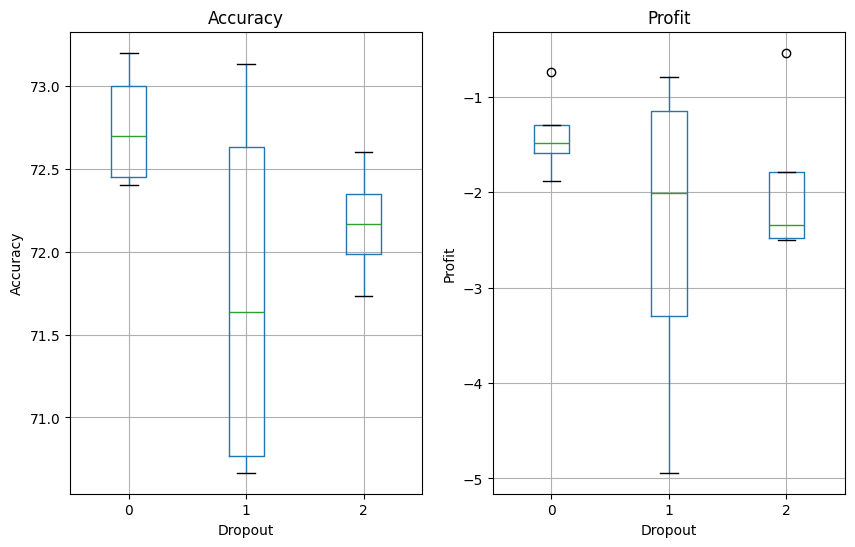

In [10]:
%matplotlib inline
print(results_acc.describe())

# 2 subplots in one row
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

# Generate boxplots
results_acc.boxplot(ax=ax[0])
results_profit.boxplot(ax=ax[1])

# Set labels and titles
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Dropout')
ax[0].set_ylabel('Accuracy')
ax[1].set_title('Profit')
ax[1].set_xlabel('Dropout')
ax[1].set_ylabel('Profit')

# Save to .png and show plot
plt.savefig(f'boxplot_model.png')
plt.show()